# Question 2

Which Actor Traits Correspond to Specific Archetypes?\
Which actor traits — such as age, gender, ethnicity, and other physical attributes — are typically associated with specific archetypes? For instance, are certain traits more frequently linked to roles like heroes, villains, or mentors? Investigating these correlations can reveal patterns in casting decisions.

In [ ]:
# ignore
%load_ext autoreload
%autoreload 2

In [ ]:
# ignore
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [ ]:
# ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from IPython import display

pio.renderers.default='notebook'
plotly.offline.init_notebook_mode(connected=True)

import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../visualization"))
from plot_3d_like import plot_2d_heatmap

In [2]:
# ignore
archetype_data = pd.read_csv('../../data/enriched/persona_identification/archetype_predictions_joined.csv')

character_data = pd.read_csv('../../data/MovieSummaries/character_processed.csv')

character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

actor_data = pd.read_csv('../../data/enriched/actors/actors_freebase.csv')
actor_data = actor_data[["education", "professions_num", "date_of_birth", "nationality", "gender", "place_of_birth", "height", "weight", "religion", "id"]]

merged = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
merged = pd.merge(merged, actor_data, how="left", left_on="actor_fb_id", right_on="id").copy()

merged.loc[merged.actor_height.isna() & ~merged.height.isna(), "actor_height"] = merged[merged.actor_height.isna() & ~merged.height.isna()].height
merged.loc[merged.actor_gender.isna() & ~merged.gender.isna(), "actor_gender"] = merged[merged.actor_gender.isna() & ~merged.gender.isna()].gender

data = merged[[
    'prediction', 'character_name',
    'movie_name', 'actor_gender', 'actor_height',
    'actor_name', 'actor_date_of_birth', 'movie_release_date', 'ethn_name',
    'race', 'education', 'professions_num', 'nationality',
    'gender', 'place_of_birth', 'weight', 'religion', "fb_movie_id", "fb_actor_id"
]].copy()
# # delete some ourliers, by looking at the histogram
MIN_HEIGHT = 0.8
MAX_HEIGHT = 2.7 # Max Palmen had height 249 cm
data = data[((data.actor_height >= MIN_HEIGHT) & (data.actor_height <= MAX_HEIGHT)) | data.actor_height.isna()].copy()
data["years_in_film"] = (pd.to_datetime(data.movie_release_date) - pd.to_datetime(data.actor_date_of_birth)).dt.days / 365.25
data["actor_bmi"] = data.weight / (data.actor_height ** 2)
data.loc[~data.education.isna(), "education"] = data.loc[~data.education.isna(), "education"].astype(str)
data.loc[data.actor_gender == "Male", "actor_gender"] = "M"
data.loc[data.actor_gender == "Female", "actor_gender"] = "F"
data.rename(columns={"prediction": "archetype"}, inplace=True)
data.shape

(87210, 21)

This question shapes our understanding of features related to specific archetypes, i.e. what are the average/most probable features for an archetype.

In [24]:
# ignore

actor_traits_numerical_columns = ["actor_height", "weight", "years_in_film", "actor_bmi"]
actor_traits_categorial_columns = ["actor_gender", "race", "education", "religion", "nationality", "place_of_birth"]

In [43]:
# ignore

data_categorial = data[actor_traits_categorial_columns + ["archetype"]].copy()
data_categorial = data_categorial.groupby("archetype").agg(lambda x: x.value_counts().index[0]).reset_index()

data_numerical = data[actor_traits_numerical_columns + ["archetype"]].copy()
data_numerical = data_numerical.groupby("archetype").agg(lambda x: x.dropna().mean()).reset_index()
archetype_features_most_probable = pd.merge(data_categorial, data_numerical, on="archetype")
archetype_features_most_probable

,archetype,actor_gender,race,education,religion,nationality,place_of_birth,actor_height,weight,years_in_film,actor_bmi
0,Caregiver / Healer,F,European,True,Catholicism,United States of America,New York City,1.700686,65.397276,42.071826,20.974190
1,Innocent / Vulnerable,F,European,False,Catholicism,United States of America,Los Angeles,1.680676,57.836413,24.451378,20.295291
2,Intellectual / Creative (Scholar/Artist/Inventor),M,European,True,Catholicism,United States of America,New York City,1.758763,67.782252,39.353574,21.365027
3,Love Interest / Romantic Partner,F,European,True,Catholicism,United States of America,Mumbai,1.706257,61.322289,31.001326,20.377126
4,Mentor / Wise Guide,M,European,True,Catholicism,United States of America,New York City,1.776903,77.673471,46.709551,23.488200
5,Mystic / Seer,M,European,True,Catholicism,United States of America,New York City,1.742670,70.441211,42.123938,22.175049
6,Other,M,European,False,Catholicism,United States of America,New York City,1.732071,70.536072,39.338174,21.608705
7,Outsider / Loner,M,European,True,Catholicism,United States of America,New York City,1.754119,73.186161,35.076492,22.653687
8,Rogue / Trickster / Con Artist,M,European,True,Catholicism,United States of America,New York City,1.768333,75.793107,39.673057,23.195485
9,Ruler / Politician,M,European,True,Catholicism,United States of America,New York City,1.794513,79.449172,49.752175,23.545650


If we calculate those features we can create a portray for every archetype, but there is quite a lot of common features:
1. `Race` if European, `Religion` is Catholicism, `Nationality` is USA, `Place of Birth` is New York City (exception for archetype `Love Interest / Romantic Partner`, where it is Mumbai and for `Innocent / Vulnerable` where it is `Los Angeles`). This is probably because most of the films are created in USA. 
2. `Gender` is Female only for `Innocent / Vulnerable`, `Caregiver / Healer	`, and `Love Interest / Romantic Partner`. 

In [71]:
# hidecode
fig = go.Figure()


for s, title in zip(
    ["actor_height", "weight", "years_in_film", "actor_bmi"],
    ["Height", "Weight", "Years in film", "BMI"],
):
    curr_values = data[s].dropna().values.reshape(-1, 1)
    mmax = np.quantile(curr_values, 0.95)
    mmin = np.quantile(curr_values, 0.05)

    scaled = (archetype_features_most_probable[s].values.reshape(-1, 1) - mmin) / (mmax - mmin)

    fig.add_trace(
        go.Scatter(
            x=archetype_features_most_probable["archetype"],
            y=scaled.flatten().round(2),
            mode="markers+lines",
            name=title,
            hovertemplate=(
                f"<b>{title}</b><br>"
                "Archetype: %{x}<br>"
                "Original Value: %{customdata[0]}<br>"
                "Scaled Value: %{y}<extra></extra>"
            ),
            customdata=archetype_features_most_probable[s].values.reshape(-1, 1).round(2),
        )
    )

fig.update_layout(
    title="Features of Archetypes",
    xaxis_title="Archetype",
    yaxis_title="Scaled Values",
    legend_title="Features",
    height=800,
    width=800,
)

fig.show()

# display.display_html(fig.to_html(full_html=False, include_plotlyjs='cdn'), raw=True)

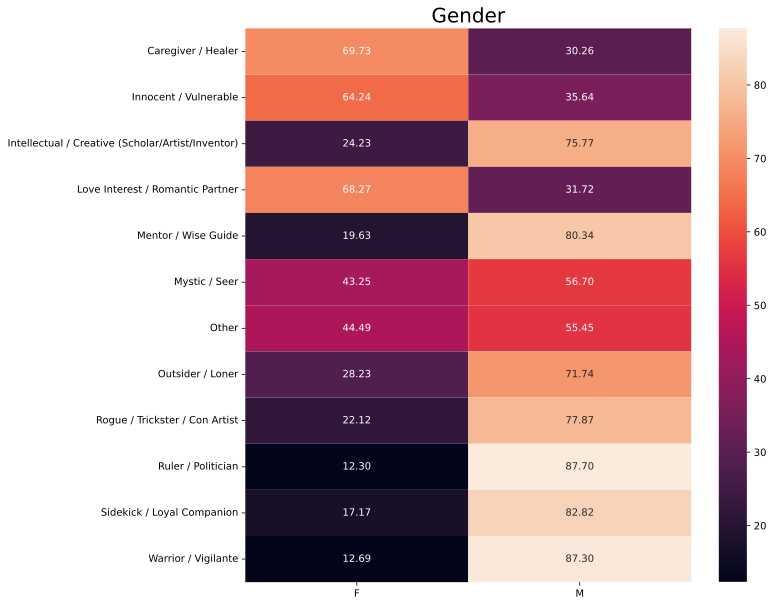

In [22]:
# hidecode

plt.figure(figsize=(1 * 10, 1 * 10))
for i, (s, title) in enumerate(zip(
    ["actor_gender"],
    ["Gender"],
)):
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="second", 
        compare_default_value="none",
        percentage=True,
        num_ybins=13,
        mht=True,
        do_not_show_x=["Other"] if title in ["Education", "Gender"] else None,
    )

This 